# Practical Machine Learning and Deep Learning
# Lesson 8


# Evolution of Generative Adversarial Networks

Generative adversarial networks (GANs) have been the go-to state of the art algorithm to image generation in the last few years. In this lab, you will learn about the most significant ones, which are GAN, CycleGAN, and StyleGAN.

## Vanilla GAN




### Idea

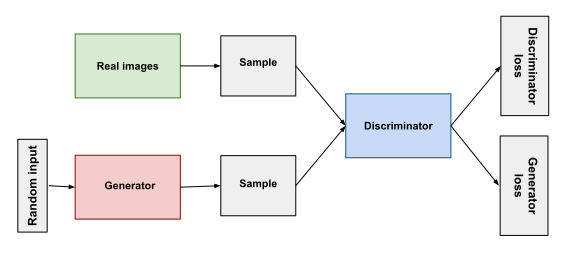

Way back in 2014, Ian Goodfellow proposed a revolutionary idea — make two neural networks compete (or collaborate, it’s a matter of perspective) with each other.

One neural network tries to **generate** realistic data (note that GANs can be used to model any data distribution, but are mainly used for images these days), and the other network tries to **discriminate** between real data and data generated by the generator network.

The generator network uses the discriminator in the loss function and updates its parameters to generate data that starts to look more realistic. The discriminator network, on the other hand, updates its parameters to make itself better at picking out fake data from real data. So it too gets better at its job.

Discriminator $D$ and Generator $G$ play the following two-player minimax game with value function $V(D, G)$:

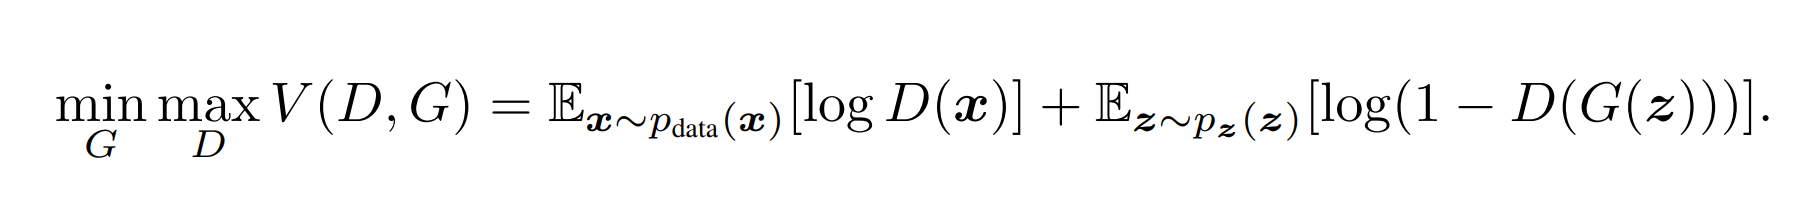

This was a brilliant idea, but it happened that GANs tend to show some inconsistencies in performance such as *mode collapse* and *convergence instability*.

### Implementation

Now, let's take a look at the implementation of a Vanilla GAN. In this example, you're going to use a GAN to generate images of handwritten digits. For that, you'll train the models using the MNIST dataset of handwritten digits, which is included in the torchvision package.

In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

In [ ]:
torch.manual_seed(111)

---

## EXERCISE 1:
Set the device type

*   If cuda is available, set torch device to cuda
*   If cuda is unavailable, set torch device to cpu
---



In [3]:
if torch.cuda.is_available():
    device = ...
else:
    device = ...

#### Preparing Training Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [ ]:
train_set = torchvision.datasets.MNIST(
    root=".", train=True, download=True, transform=transform
)

In [6]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

---

## EXERCISE 2:


*   Creates an iterator from the `train_loader`
*   Retrieve the next item from the iterator and assign them to `real_samples` and `mnist_labels`
---



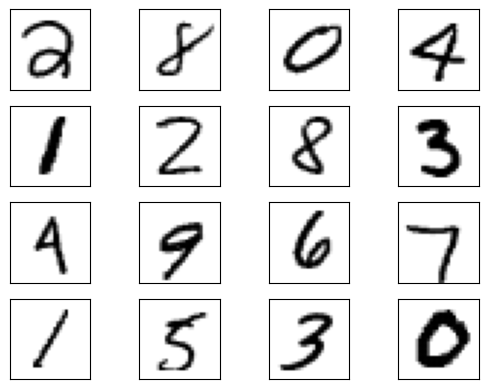

In [11]:
real_samples, mnist_labels = ...
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
assert len(real_samples)==32
assert len(mnist_labels)==32
print("Test case passed")

#### Discriminator Implementation

In this case, the discriminator is an MLP neural network that receives a 28 × 28 pixel image and provides the probability of the image belonging to the real training data.

---

## EXERCISE 3: Build a discriminator model

In this exercise, you will build a neural network using PyTorch. The network will consist of fully connected layers, activation functions, and dropout layers to prevent overfitting. Follow the steps below to construct the model.

1. **Define the input and output sizes for the first fully connected layer**:
    - Input size: 784 (e.g., for a 28x28 pixel image)
    - Output size: 1024

2. **Add a ReLU activation function** after the first fully connected layer.

3. **Add a dropout layer**:
    - Dropout probability: 0.3 (30% of the neurons will be randomly set to zero during training).

4. **Define the input and output sizes for the second fully connected layer**:
    - Input size: 1024 (from the previous layer's output)
    - Output size: 512

5. **Add a ReLU activation function** after the second fully connected layer.

6. **Add another dropout layer** with the same dropout probability of 0.3.

7. **Define the input and output sizes for the third fully connected layer**:
    - Input size: 512 (from the previous layer's output)
    - Output size: 256

8. **Add a ReLU activation function** after the third fully connected layer.

9. **Add another dropout layer** with the same dropout probability of 0.3.

10. **Define the input and output sizes for the fourth fully connected layer**:
    - Input size: 256 (from the previous layer's output)
    - Output size: 1

11. **Add a Sigmoid activation function** after the fourth fully connected layer to output a probability for binary classification.

---

In [13]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            ...
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

discriminator = Discriminator().to(device=device)

In [ ]:
def assert_discriminator_structure(model):
    layers = list(model.model.children())

    # Assert the number of layers
    assert len(layers) == 11, f"Expected 11 layers, but got {len(layers)}."

    # Assert layer types and parameters
    assert isinstance(layers[0], nn.Linear), "Layer 1 should be nn.Linear."
    assert layers[0].in_features == 784, "Layer 1 should have 784 input features."
    assert layers[0].out_features == 1024, "Layer 1 should have 1024 output features."

    assert isinstance(layers[1], nn.ReLU), "Layer 2 should be nn.ReLU."

    assert isinstance(layers[2], nn.Dropout), "Layer 3 should be nn.Dropout."
    assert layers[2].p == 0.3, "Layer 3 should have a dropout probability of 0.3."

    assert isinstance(layers[3], nn.Linear), "Layer 4 should be nn.Linear."
    assert layers[3].in_features == 1024, "Layer 4 should have 1024 input features."
    assert layers[3].out_features == 512, "Layer 4 should have 512 output features."

    assert isinstance(layers[4], nn.ReLU), "Layer 5 should be nn.ReLU."

    assert isinstance(layers[5], nn.Dropout), "Layer 6 should be nn.Dropout."
    assert layers[5].p == 0.3, "Layer 6 should have a dropout probability of 0.3."

    assert isinstance(layers[6], nn.Linear), "Layer 7 should be nn.Linear."
    assert layers[6].in_features == 512, "Layer 7 should have 512 input features."
    assert layers[6].out_features == 256, "Layer 7 should have 256 output features."

    assert isinstance(layers[7], nn.ReLU), "Layer 8 should be nn.ReLU."

    assert isinstance(layers[8], nn.Dropout), "Layer 9 should be nn.Dropout."
    assert layers[8].p == 0.3, "Layer 9 should have a dropout probability of 0.3."

    assert isinstance(layers[9], nn.Linear), "Layer 10 should be nn.Linear."
    assert layers[9].in_features == 256, "Layer 10 should have 256 input features."
    assert layers[9].out_features == 1, "Layer 10 should have 1 output feature."

    assert isinstance(layers[10], nn.Sigmoid), "Layer 11 should be nn.Sigmoid."

    print("All assertions passed!")

assert_discriminator_structure(discriminator)


#### Generator Implementation

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image.


---

## EXERCISE 4: Build a generator model

In this exercise, you will build a neural network using PyTorch. The network will consist of fully connected layers and activation functions. Follow the steps below to construct the model.

1. **Define the input and output sizes for the first fully connected layer**:
    - Input size: 100
    - Output size: 256

2. **Add a ReLU activation function** after the first fully connected layer.

3. **Define the input and output sizes for the second fully connected layer**:
    - Input size: 256 (from the previous layer's output)
    - Output size: 512

4. **Add a ReLU activation function** after the second fully connected layer.

5. **Define the input and output sizes for the third fully connected layer**:
    - Input size: 512 (from the previous layer's output)
    - Output size: 1024

6. **Add a ReLU activation function** after the third fully connected layer.

7. **Define the input and output sizes for the fourth fully connected layer**:
    - Input size: 1024 (from the previous layer's output)
    - Output size: 784

8. **Add a Tanh activation function** after the fourth fully connected layer to normalize the output between -1 and 1.


---

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            ...
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)

In [ ]:
def assert_model_structure(model):
    layers = list(model.model.children())

    # Assert the number of layers
    assert len(layers) == 8, f"Expected 8 layers, but got {len(layers)}."

    # Assert layer types and parameters
    assert isinstance(layers[0], nn.Linear), "Layer 1 should be nn.Linear."
    assert layers[0].in_features == 100, "Layer 1 should have 100 input features."
    assert layers[0].out_features == 256, "Layer 1 should have 256 output features."

    assert isinstance(layers[1], nn.ReLU), "Layer 2 should be nn.ReLU."

    assert isinstance(layers[2], nn.Linear), "Layer 3 should be nn.Linear."
    assert layers[2].in_features == 256, "Layer 3 should have 256 input features."
    assert layers[2].out_features == 512, "Layer 3 should have 512 output features."

    assert isinstance(layers[3], nn.ReLU), "Layer 4 should be nn.ReLU."

    assert isinstance(layers[4], nn.Linear), "Layer 5 should be nn.Linear."
    assert layers[4].in_features == 512, "Layer 5 should have 512 input features."
    assert layers[4].out_features == 1024, "Layer 5 should have 1024 output features."

    assert isinstance(layers[5], nn.ReLU), "Layer 6 should be nn.ReLU."

    assert isinstance(layers[6], nn.Linear), "Layer 7 should be nn.Linear."
    assert layers[6].in_features == 1024, "Layer 7 should have 1024 input features."
    assert layers[6].out_features == 784, "Layer 7 should have 784 output features."

    assert isinstance(layers[7], nn.Tanh), "Layer 8 should be nn.Tanh."

    print("All assertions passed!")

assert_model_structure(generator)

#### Training

Set up hyperparameters and separate optimizers for generator and discriminator


In [15]:
lr = 0.0001
num_epochs = 10
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

The following steps happen during a training iteration:
1. Discriminator training  
The weights of the disciminator are optimized using Binary Cross Entropy Loss built on a set of real and fake images. Real images are labeled as 1. Fake images are generated by the generator and labeled as 0.
2. Generator training  
After the discriminator was trained, the weights of a generator are also optimized using Binary Cross Entropy Loss built on a set of fake images that the generator produces from a random noise.


In [ ]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

#### Checking the Samples Generated by the GAN

Produce the samples from a random noise and show them

In [23]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

Unfortunately, Vanilla GAN has several major drawbacks. One of them is a mode collapse, when the generator stucks at a local extremum and produces the same image all the time. Here is an example of mode collapse:

In [ ]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

## CycleGAN

### Idea

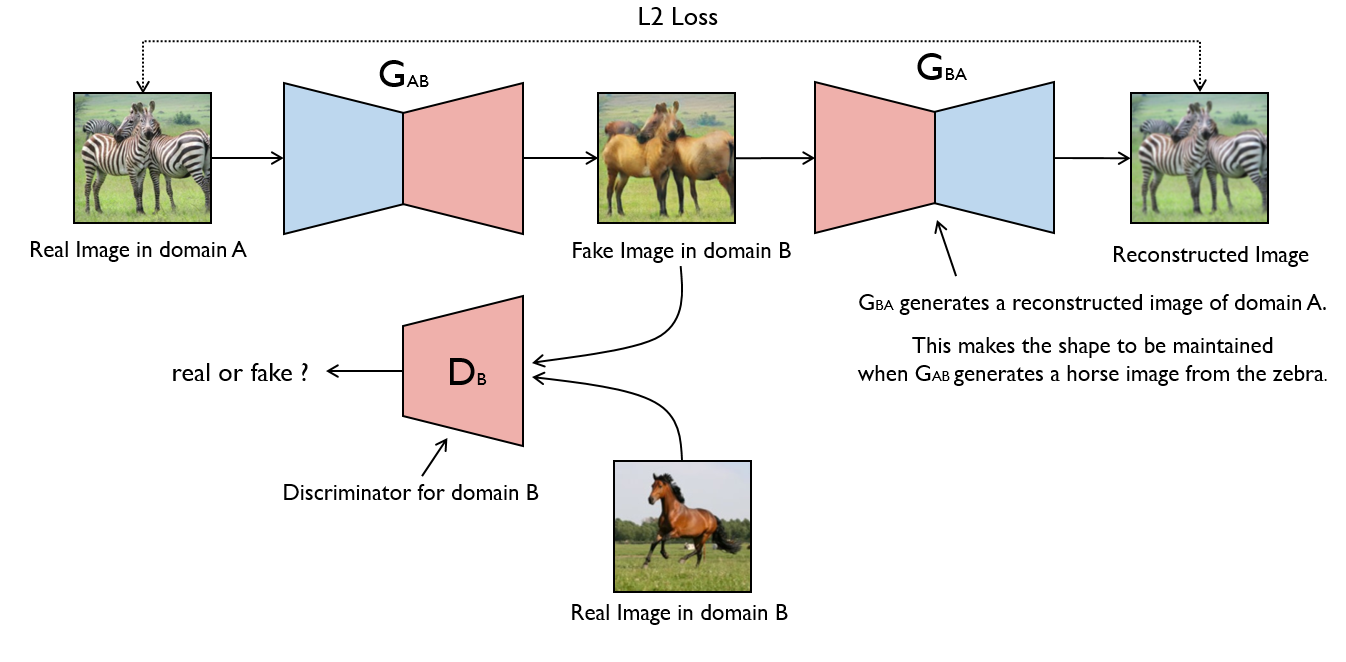

GANs aren't used just for generating images. CycleGAN aims to solve a problem of image-to-image translation. It involves producing another image from a given image. An example of such translation could be generating an image of a horse from the image of a zebra.

The task here is to train a network $G(X)$ that maps images from a source domain $X$ (e.g. images of zebras) to a target domain $Y$ (e.g. images of horses).

CycleGAN consists of two generators $G$ and $F$, and two discriminators $D_X$ and $D_Y$. $G$ takes in an image from $X$ and tries to map it to some image in
$Y$. The discriminator $D_Y$ predicts whether an image was generated by $G$ or was actually in $Y$. Similarly, $F$ takes in an image from $Y$ and tries to map it to some image in $X$, and the discriminator $D_X$ predicts whether an image was generated by $F$ or was actually in $X$.

All four networks are trained in the usual GAN way until we're left with powerful generators $G$ and $F$, which can perform the image-to-image translation task well enough to fool $D_Y$ and $D_X$ respectively.

This type of adversarial loss sounds like a good idea. But it isn't enough. To further improve performance, CycleGAN uses another metric, cycle consistency loss. The property of a good translator is having the same thing after translation back and forth. It forces the network to obey the following constraints:
$$F(G(X)) \approx x, x \in X$$
and
$$G(F(Y)) \approx y, y \in Y.$$  
Basically, it means that an image of a zebra after translating to an image of horse and translating back to the image of a zebra should be the same image of zebra.

$L_{GAN}$ is the generative adversarial loss from the original GAN paper.

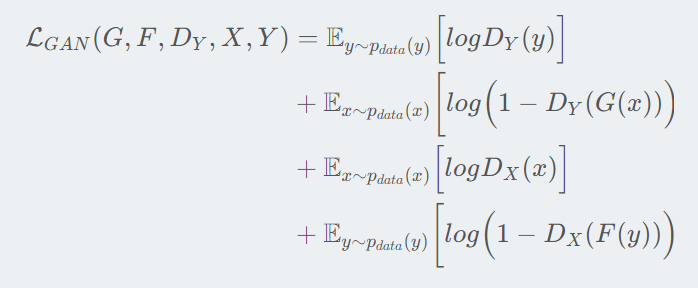

However, it turns out that the images after translating back and fourth lose their color. To overcome this, the authors of CycleGAN paper proposed to use an identity loss.

$L_{cyc}$ is the cyclic loss, where we try to get $F(G(x))$ to be similar to $x$, and $G(F(y))$ to be similar to y. Basically if the two generators (transformations) are applied in series it should give back the original image.

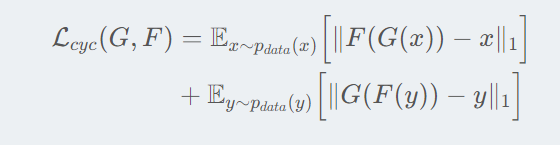

$L_{identity}$ is the identity loss. This was used to encourage the mapping to preserve color composition between the input and the output.

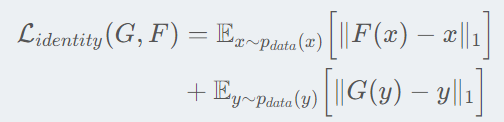

The combined loss including GAN, cycle-consistency loss, and identity loss looks like this

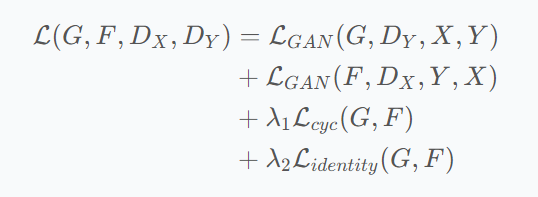

The overall loss function is constructed in a way that penalizes the networks for not conforming to the above properties.

### Implementation

To understand better how CycleGAN works, check the following implementation. Here we build a CycleGAN on the sets of photos and Monet paintings to transform photos to Monet paintings and vice versa.

#### Download Images and Import Libraries

In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/cyclegan/datasets/monet2photo.zip
!unzip monet2photo.zip
!mv monet2photo/trainA monet2photo/monet_jpg
!mv monet2photo/trainB monet2photo/photo_jpg

In [34]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

#### Initiate Settings

In [35]:
n_cpu = 2 # number of cpu threads to use during batch generation

# data (path)
dataset_name = 'monet2photo'
root = './'+dataset_name

# data (img)
img_height = 256
img_width = 256
channels = 3

# training
epoch = 0 # epoch to start training from
n_epochs = 5 # number of epochs of training
batch_size = 1 # size of the batches
lr = 0.0002 # adam : learning rate
b1 = 0.5 # adam : decay of first order momentum of gradient
b2 = 0.999 # adam : decay of first order momentum of gradient
decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                 # epoch from which to start lr decay

#### Define Generator

The generator performs downsampling, residual blocks processing, and upsampling.
The residual blocks add a tensor modified by two convolution layers to the input tensor.



---

## EXERCISE 5: Build a Residual Block

Define all the layers within the sequential block.


1.   ReflectionPad2d(1): Pads the input tensor using the reflection of the input boundary. This helps in maintaining image quality at the edges.
2.   Conv2d(in_features, in_features, 3): A 2D convolutional layer with in_features input and output channels, and a kernel size of 3.

  Parameters:

  in_features: Number of input channels.

  in_features: Number of output channels (same as input channels here).

3.   InstanceNorm2d(in_features): Normalizes the samples based on their individual means and deviations.
  Parameter: in_features which is the number of features or channels in the input.

4.   ReLU(inplace=True): Applies the ReLU activation function in place.

  Parameter: inplace=True which modifies the input directly, saving memory.
5.   ReflectionPad2d(1): Another reflection padding layer with the same parameter as the first.
6.   Conv2d(in_features, in_features, 3): Another 2D convolutional layer with the same parameters as the first convolutional layer.

7.   InstanceNorm2d(in_features): Another instance normalization layer with the same parameter as the first.
---

In [36]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            ...
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_block):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial Convolution Block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_block):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2), # --> width*2, heigh*2
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # Output Layer
        model += [nn.ReflectionPad2d(channels),
                  nn.Conv2d(out_features, channels, 7),
                  nn.Tanh()
                 ]

        # Unpacking
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

#### Define Discriminator

Output of the discriminator is a map of probabilities, whether each region of the image is real or generated. The discriminator uses a sequence of special blocks that shrink the height and width by a factor of 2. At the end it does convolution with $4 \times 4$ filter that used to make a decision.


---

## EXERCISE 6: Build a Discriminator Model


   - Create a `nn.Sequential` model that stacks the discrminator blocks:
     - From `channels` to 64 filters without normalization (`normalize=False`).
     - From 64 to 128 filters.
     - From 128 to 256 filters.
     - From 256 to 512 filters.
   - Add a `nn.ZeroPad2d` layer to adjust the output size.
   - Finally, add a `nn.Conv2d` layer with input channels=512, output channels=1, kernel size=4, and padding=1.


---


In [37]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height//2**4, width//2**4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *...
        )

    def forward(self, img):
        return self.model(img)

#### Define Loss

In [38]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

#### Initialize Generator and Discriminator

In [39]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 9 # suggested default, number of residual blocks in generator

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

#### GPU Setting

In [40]:
cuda = torch.cuda.is_available()

if cuda:
    G_AB = G_AB.cuda()
    G_BA = G_BA.cuda()
    D_A = D_A.cuda()
    D_B = D_B.cuda()

    criterion_GAN.cuda()
    criterion_cycle.cuda()
    criterion_identity.cuda()

### Weight Setting

It is often recommended to initialize the weights of the models randomly according to normal disribution $N(0,0.2)$

In [41]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)

In [ ]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

#### Configure Optimizers

In [43]:
import itertools
# lr = 0.0002
# b1 = 0.5
# b2 = 0.999

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D_A = torch.optim.Adam(
    D_A.parameters(), lr=lr, betas=(b1,b2)
)
optimizer_D_B = torch.optim.Adam(
    D_B.parameters(), lr=lr, betas=(b1,b2)
)

#### Learning Rate Scheduler Setting

Create the learning rate schedules. The learning rate stars flat until `decay_start` epochs, and then linearly reduce to 0 at end of training.

In [44]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [45]:
# n_epochs = 10
# epoch = 0
# decay_epoch = 5


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B,
    lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
)

#### Image Transformation Setting

In [46]:
from PIL import Image
import torchvision.transforms as transforms

transforms_ = [
    transforms.Resize(int(img_height*1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]

### DataLoader Setting

Create utility function to ensure the image is RGB

In [47]:
def to_rgb(image):
    rgb_image = Image.new("RGB", image.size)
    rgb_image.paste(image)
    return rgb_image

Make a dataset class for the dataset of Monet images and photos to load them and perform transformations

In [48]:
import os
import glob
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.mode = mode
        if self.mode == 'train':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[:250])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[:250])
        elif self.mode == 'test':
            self.files_A = sorted(glob.glob(os.path.join(root+'/monet_jpg')+'/*.*')[250:])
            self.files_B = sorted(glob.glob(os.path.join(root+'/photo_jpg')+'/*.*')[250:301])

    def  __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[np.random.randint(0, len(self.files_B)-1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])
        if image_A.mode != 'RGB':
            image_A = to_rgb(image_A)
        if image_B.mode != 'RGB':
            image_B = to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {'A':item_A, 'B':item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

Make dataloaders

In [49]:
dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True),
    batch_size=1, # 1
    shuffle=True,
    num_workers=n_cpu # 3
)

val_dataloader = DataLoader(
    ImageDataset(root, transforms_=transforms_, unaligned=True, mode='test'),
    batch_size=5,
    shuffle=True,
    num_workers=n_cpu
)

#### Define function to get sample images

In [50]:
import matplotlib.pyplot as plt

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

def sample_images():
    """show a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = imgs['A'].type(Tensor) # A : monet
    fake_B = G_AB(real_A).detach()
    real_B = imgs['B'].type(Tensor) # B : photo
    fake_A = G_BA(real_B).detach()
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    plt.imshow(image_grid.cpu().permute(1,2,0))
    plt.title('Real A vs Fake B | Real B vs Fake A')
    plt.axis('off')
    plt.show();

In [ ]:
sample_images()

#### Training

In [ ]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):

        # Set model input
        real_A = batch['A'].type(Tensor)
        real_B = batch['B'].type(Tensor)

        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.

# -----------------
# Train Generators
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode

        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)

        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2

        # GAN Loss
        fake_B = G_AB(real_A) # fake_B is fake-photo that generated by real monet-drawing
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'

        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

        # Cycle Loss
        recov_A = G_BA(fake_B) # recov_A is fake-monet-drawing that generated by fake-photo
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B)/2

# ------> Total Loss
        loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)

        loss_G.backward()
        optimizer_G.step()

# -----------------
# Train Discriminator A
# -----------------
        optimizer_D_A.zero_grad()

        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake

        loss_D_A = (loss_real + loss_fake)/2

        loss_D_A.backward()
        optimizer_D_A.step()

# -----------------
# Train Discriminator B
# -----------------
        optimizer_D_B.zero_grad()

        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake

        loss_D_B = (loss_real + loss_fake)/2

        loss_D_B.backward()
        optimizer_D_B.step()

# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2

# -----------------
# Show Progress
# -----------------
        if (i+1) % 50 == 0:
            print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                    %(epoch+1,n_epochs,       # [Epoch -]
                      i+1,len(dataloader),   # [Batch -]
                      loss_D.item(),       # [D loss -]
                      loss_G.item(),       # [G loss -]
                      loss_GAN.item(),     # [adv -]
                      loss_cycle.item(),   # [cycle -]
                      loss_identity.item(),# [identity -]
                     ))

In [ ]:
sample_images()

* [Generative Adversarial Networks - The Story So Far](https://blog.floydhub.com/gans-story-so-far/)
* [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/)
* [CycleGAN Tutorial from Scratch: Monet-to-Photo](https://www.kaggle.com/code/songseungwon/cyclegan-tutorial-from-scratch-monet-to-photo)
* [PyTorch implementation/tutorial of Cycle GAN by labml.ai](https://nn.labml.ai/gan/cycle_gan/index.html)